# Mini neural net training
Authors: Alfredo Canziani, Philipp Schmitt  
Date: Tue 24 Feb 2020

In [3]:
import torch
from torch import nn, optim
from IPython import display
from PIL import Image, ImageFont, ImageDraw
from matplotlib.pyplot import imshow, axis, figure, subplot, pause
import numpy
import random
import math

%matplotlib inline

In [4]:
# static random seed
torch.manual_seed(0)

In [5]:
# Input definition
class input_settings:
    batch_size = 1
    channels = 1
    height = 8
    width = 8

dummy_X = torch.randn(  # batch of inputs x
    input_settings.batch_size,
    input_settings.channels,
    input_settings.height,
    input_settings.width,
)

In [6]:
# Network architecture
class model_settings:
    conv_channels = 4
    kernel = 3
    pooling_kernel = 3
    flattened = 16
    output_size = 1
    
model = nn.Sequential(
    nn.Conv2d(
        in_channels=input_settings.channels,
        out_channels=model_settings.conv_channels,
        kernel_size=model_settings.kernel,
        bias=True,
    ),
    nn.ReLU(),
    nn.MaxPool2d(
        kernel_size=model_settings.pooling_kernel,
        stride=model_settings.pooling_kernel,
    ),  # we have 4 x 2x2
    nn.Flatten(),  # gives 16
    nn.Linear(
        in_features=model_settings.flattened,
        out_features=model_settings.output_size,
        bias=True,
    ),
)

In [7]:
# Inference
with torch.no_grad():
    print(model(dummy_X).size())

torch.Size([1, 1])


In [8]:
# Print the model architecture
print(model)

Sequential(
  (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (3): Flatten()
  (4): Linear(in_features=16, out_features=1, bias=True)
)


In [9]:
# Get weights and biases
def get_weights():
    print(
        model[0],
        model[0].weight,
        model[0].bias,
        sep='\n',
    )
    print(
        model[4],
        model[4].weight,
        model[4].bias,
        sep='\n',
    )
    # Maybe add some saving routines

In [10]:
font = ImageFont.truetype('Verdana', 8)  # let's keep it to Verdana 8pt
data_set_settings = dict(
    D=dict(
        x_min = -1,
        x_max = 2,
        y_min = -3,
        y_max = -1,
    ),
    C=dict(
        x_min = 0,
        x_max = 3,
        y_min = -4,
        y_max = -2,
    )
)

In [11]:
def generate_data(visualise=False, target=None):
    image = Image.new('L', (input_settings.height, input_settings.width))
    draw = ImageDraw.Draw(image)
    draw.fontmode = '1'
    if not target:
        character = random.choice(('C', 'D'))
    else:
        character = target

    x = random.randint(
        data_set_settings[character]['x_min'],
        data_set_settings[character]['x_max'],
    )
    y = random.randint(
        data_set_settings[character]['y_min'],
        data_set_settings[character]['y_max'],
    )

    draw.text((x, y), character, (255,), font=font)
    data = numpy.array(image, dtype=numpy.float32) / 255
    
    if visualise:
        figure(facecolor='k')
        imshow(data, cmap='gray')
        axis('off');
    
    return torch.tensor(data).unsqueeze_(0), torch.tensor(character=='C', dtype=torch.float)

(tensor([[[0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 1., 1., 1.],
          [0., 0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 1., 0., 0., 0., 0.],
          [0., 0., 0., 1., 0., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 1., 1., 1.]]]), tensor(1.))

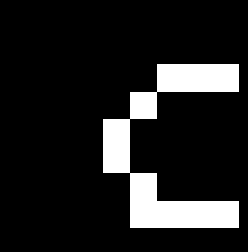

In [12]:
generate_data(visualise=True)

In [13]:
# letter samples
samples = [
    [
        [0,1,1,1],
        [1,0,0,0],
        [1,0,0,0],
        [1,0,0,0],
        [1,0,0,0],
        [0,1,1,1]
    ],
    [
        [1,1,1],
        [1,0,0],
        [1,0,0],
        [1,1,1]
    ],
    [
        [1,1,1,0],
        [1,0,0,1],
        [1,0,0,1],
        [1,0,0,1],
        [1,0,0,1],
        [1,1,1,0]
    ],
    [
        [1,1,0],
        [1,0,1],
        [1,0,1],
        [1,1,0]
    ]
]

sample_meta = [
    [6,4,'C'],
	[4,3,'C'],
	[6,4,'D'],
	[4,3,'D']
]

(tensor([[[0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 1., 1., 1., 0.],
          [0., 0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 1., 1., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0.]]]), tensor(1.))

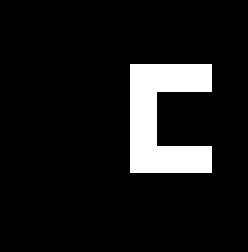

In [14]:
# updated gen. function to match teensy implementation
def generate_data(visualise=False, target=None):
    data = numpy.zeros(shape=(8,8), dtype=numpy.float32)
    
    sample = random.randint(0,len(samples)-1)
    character = sample_meta[sample][2];
    
    x = random.randint(
        0,
        input_settings.width-sample_meta[sample][1]
    )
    y = random.randint(
        0,
        input_settings.height-sample_meta[sample][0]
    )
    
    data[y:y+sample_meta[sample][0],x:x+sample_meta[sample][1]] = samples[sample]
    
    if visualise:
        figure(facecolor='k')
        imshow(data, cmap='gray')
        axis('off');
        
    return torch.tensor(data).unsqueeze_(0), torch.tensor(character=='C', dtype=torch.float)
        
generate_data(visualise=True)

In [15]:
# Generate a C, D batch
def get_batch(visualise=False):
    Cx, Cy = generate_data(target='C', visualise=visualise)
    Dx, Dy = generate_data(target='D', visualise=visualise)
    x = torch.stack((Cx, Dx))
    y = torch.stack((Cy, Dy))
    return x, y

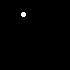

In [16]:
from PIL import Image, ImageDraw
from numpy import interp
from math import cos, sin, radians, pi


def draw_weight(value, size=20):
    rad = interp(value,[-.75,.75],[pi,0])
    im = Image.new('RGB', (size, size), (0, 0, 0))
    draw = ImageDraw.Draw(im)
    x, y, r = (
        size/2 + size/3 * cos(rad), 
        size/2 - size/3 * sin(rad),
        4)
    draw.ellipse((x-r/2, y-r/2, x+r/2, y+r/2), fill=(255, 255, 255), outline=None)

    return im

draw_weight(-.25, 70)

In [17]:
# draw weights

def draw_weights(layer, size=20):
    weights = layer.weight.data.clone().numpy()

    n_weights = len(weights[0])
    im = Image.new('RGB', ((size+1)*n_weights, size), (255, 255, 255))

    for i in range(n_weights):
        weight = draw_weight(weights[0][i], size=size)
        im.paste(weight,((size+1)*i,0))

    return im

draw_weights(model[4], size=30)

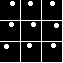

In [18]:
# draw a filter
def draw_filter(filter):
    matrix = Image.new('RGB', (63, 63), (255, 255, 255))
    data = filter.view(3, 3).numpy()
    # go over filter
    # rows
    for x in range(0, data.shape[0]):
        # cols
        for y in range(0, data.shape[1]):
            vis = draw_weight(data[y,x])
            matrix.paste(vis,(x*21,y*21))
    return matrix

filters = model[0].weight.data
draw_filter(filters[0])

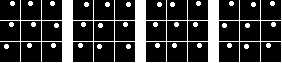

In [19]:
# draw all filters
def draw_filters(layer):
    matrix = Image.new('RGB', (282, 63), (255, 255, 255))
    filters = layer.weight.data.clone()
    for i, filter in enumerate(filters):
        vis = draw_filter(filter)
        matrix.paste(vis, (i*(63+10),0))
    return matrix


draw_filters(model[0])

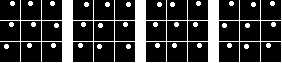

In [20]:
draw_filters(model[0])

In [21]:
#model[0].weight.data.fill_(0)
#model[4].weight.data.fill_(0)

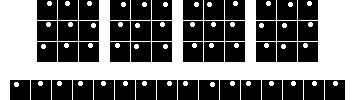

In [22]:
# draw all the weights in the net
def draw_net():
    im = Image.new('RGB', (356, 100), (255, 255, 255))
    im.paste(draw_filters(model[0]), (37,0))
    im.paste(draw_weights(model[4]), (10,80))

    return im

draw_net()

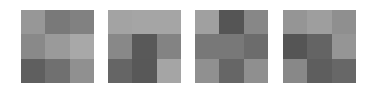

In [23]:
# Visualize weights
def visualize_filters(layer):
    filters = layer.weight.data.clone()
    # visualize
    for i in range(0, len(filters)):
        data = filters[i].view(3, 3)
        subplot(1, 4, i+1)
        imshow(data, cmap='gray', vmin=-1, vmax=1)
        axis('off');
        
visualize_filters(model[0])

---
# Training

In [24]:
# Set up network training
nb_epochs = 10_000
optimiser = optim.SGD(params=model.parameters(), lr=1e-4)
#loss = nn.BCEWithLogitsLoss()
loss = nn.BCEWithLogitsLoss()

In [356]:
# Training
for epoch in range(nb_epochs):
    # Training steps
    X, Y = generate_data()
    logits = model(X.unsqueeze(0))  # feed-forward
    
    # not sure if I'm doing this right ...
    logits = logits.squeeze(-2)
    Y = Y.unsqueeze(0)

    J = loss(logits, Y)  # computes the loss
    model.zero_grad()  # cleans up previous gradients
    J.backward()
    optimiser.step()
    
    # Accuracy computation and display
    score, predicted = torch.max(logits, 0)
    acc = (Y == (logits > 0)).sum().float() / len(Y)

    if(epoch % 100 == 0):
        display.clear_output(wait=True)
        print("[EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (epoch, J.item(), acc))
        
        print(model[0].weight.data)
        
        figure(figsize=(10, 20))
        #visualize_filters(model[0])
        im = draw_net()
        imshow(numpy.asarray(im), aspect='equal', interpolation='nearest')
        
        # im.save('%s.png' % epoch)
        
        #draw_filters(model[0]).save('%i.png' % epoch)
        axis('off');
        pause(0.1)

[EPOCH]: 900, [LOSS]: 0.587386, [ACCURACY]: 1.000
tensor([[[[ 0.2583,  0.1130,  0.1664],
          [ 0.1290, -0.1066,  0.5152],
          [-0.1506, -0.3007,  0.5802]]],


        [[[ 0.4498,  0.4808,  0.4108],
          [-0.2379, -0.3478, -0.2646],
          [-0.3933, -0.3176,  0.0442]]],


        [[[ 0.4306, -0.3333,  0.0822],
          [-0.1255, -0.1022, -0.1554],
          [ 0.0010, -0.2646,  0.0243]]],


        [[[ 0.4248,  0.3947,  0.2808],
          [-0.4287, -0.3338,  0.0354],
          [-0.0901, -0.3116, -0.3454]]]])


KeyboardInterrupt: 

C


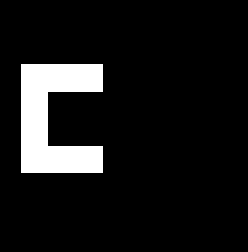

In [236]:
# Inference: C vs. D detector
with torch.no_grad():
    print('C' if model(generate_data(visualise=True)[0].unsqueeze_(0)) > 0 else 'D')

In [28]:
# register hook to get activation after conv layer out

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model[0].register_forward_hook(get_activation('act'))
model[1].register_forward_hook(get_activation('relu'))
model[2].register_forward_hook(get_activation('pool'))
model[3].register_forward_hook(get_activation('flatten'))

D
tensor([[[[ 0.3136,  0.3136,  0.3136,  0.3136,  0.3136,  0.3136],
          [ 0.3136,  0.3136,  0.3136,  0.3136,  0.3136,  0.3136],
          [ 0.4446,  0.3224,  0.0656, -0.0654,  0.0567,  0.3136],
          [ 0.7647,  0.7183,  0.6608,  0.5976,  0.3908,  0.3136],
          [ 0.7774,  0.3689,  0.2876,  0.4545,  0.4966,  0.3136],
          [ 0.7774,  0.4871,  0.3258, -0.0654,  0.0567,  0.3136]],

         [[ 0.2246,  0.2246,  0.2246,  0.2246,  0.2246,  0.2246],
          [ 0.2246,  0.2246,  0.2246,  0.2246,  0.2246,  0.2246],
          [ 0.5208,  0.2101,  0.0016, -0.2946,  0.0161,  0.2246],
          [ 0.5514, -0.3452, -0.1768,  0.0011,  0.2909,  0.2246],
          [ 0.8456,  0.2083,  0.9428,  0.7909,  0.5008,  0.2246],
          [ 0.8456,  0.2103,  0.3441, -0.2946,  0.0161,  0.2246]],

         [[-0.1453, -0.1453, -0.1453, -0.1453, -0.1453, -0.1453],
          [-0.1453, -0.1453, -0.1453, -0.1453, -0.1453, -0.1453],
          [-0.0231, -0.2206, -0.0924, -0.2146, -0.0172, -0.1453],
    

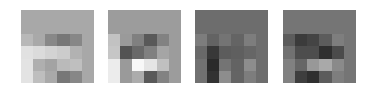

In [29]:
# Inference: C vs. D detector
with torch.no_grad():
    print('C' if model(generate_data(visualise=False)[0].unsqueeze_(0)) > 0 else 'D')
    print(activation['act'])
    
    # visualize activations after convolution
    for i, act in enumerate(activation['act'][0]):
        print(act)
        data = act.view(6,6)
        subplot(1, 4, i+1)
        imshow(data, cmap='gray', vmin=-1, vmax=1)
        axis('off');

---
# A printout of sample data, activations, outputs to troubleshoot Teensy implementation

(tensor([[[0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 1., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 1., 0., 0.],
         [0., 0., 1., 1., 1., 0., 0., 0.]]]), tensor(0.))


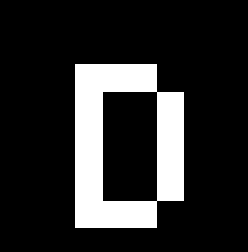

In [37]:
dat = generate_data(visualise=True)
print(dat)

In [33]:
get_weights()

Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
Parameter containing:
tensor([[[[ 0.1830, -0.0421,  0.0127],
          [ 0.0772,  0.2068,  0.3201],
          [-0.2569, -0.1222,  0.1310]]],


        [[[ 0.2762,  0.2901,  0.2941],
          [ 0.0663, -0.2899,  0.0307],
          [-0.2085, -0.3107,  0.2962]]],


        [[[ 0.2535, -0.3325,  0.0624],
          [-0.0562, -0.0549, -0.1526],
          [ 0.1282, -0.1974,  0.1222]]],


        [[[ 0.1686,  0.2386,  0.1246],
          [-0.3299, -0.2162,  0.1664],
          [ 0.0698, -0.2600, -0.1919]]]], requires_grad=True)
Parameter containing:
tensor([ 0.3136,  0.2246, -0.1453, -0.0839], requires_grad=True)
Linear(in_features=16, out_features=1, bias=True)
Parameter containing:
tensor([[-0.2381, -0.0045, -0.1883, -0.1928, -0.0138,  0.0375, -0.1024,  0.1483,
         -0.1521,  0.2268,  0.1713, -0.2108, -0.0622,  0.0113,  0.0365,  0.0593]],
       requires_grad=True)
Parameter containing:
tensor([0.0981], requires_grad=True)


D
tensor([[ 0.3224,  0.0656, -0.0654,  0.0567,  0.3136,  0.3136],
        [ 0.7183,  0.6608,  0.7286,  0.2687,  0.0567,  0.3136],
        [ 0.3689,  0.2876,  0.9056,  0.5812,  0.1339,  0.3136],
        [ 0.3561,  0.3169,  0.7774,  0.3561,  0.3169,  0.3136],
        [ 0.3561,  0.3169,  0.7774,  0.3561,  0.3169,  0.3136],
        [ 0.4871,  0.3258,  0.2673,  0.2214,  0.5738,  0.3136]])
tensor([[ 0.2101,  0.0016, -0.2946,  0.0161,  0.2246,  0.2246],
        [-0.3452, -0.1768,  0.2972, -0.0197,  0.0161,  0.2246],
        [ 0.2083,  0.9428,  1.1177, -0.0997,  0.0824,  0.2246],
        [-0.0858,  0.3586,  0.8456, -0.0858,  0.3586,  0.2246],
        [-0.0858,  0.3586,  0.8456, -0.0858,  0.3586,  0.2246],
        [ 0.2103,  0.3441,  0.0302,  0.0163,  0.5671,  0.2246]])
tensor([[-0.2206, -0.0924, -0.2146, -0.0172, -0.1453, -0.1453],
        [-0.5502, -0.2807, -0.1342, -0.3989, -0.0172, -0.1453],
        [-0.6677, -0.0900, -0.2548, -0.1442, -0.0733, -0.1453],
        [-0.7301,  0.1801, -0.1133, 

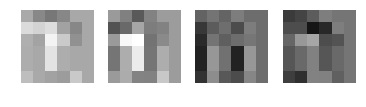

In [34]:
with torch.no_grad():
    #dat = generate_data(visualise=False)
    x = dat[0].unsqueeze_(0)
    print('C' if model(x) > 0 else 'D')
    
    # visualize activations after convolution
    for i, act in enumerate(activation['act'][0]):
        print(act)
        data = act.view(6,6)
        subplot(1, 4, i+1)
        imshow(data, cmap='gray', vmin=-1, vmax=1)
        axis('off');
    
    print("\n")
    
    print("relu:")
    print(activation["relu"])
    print("\n")
    
    print("pool:")
    print(activation["pool"])
    print("\n")
    
    print("flatten:")
    print(activation["flatten"])
    print("\n")
    
    

---
# Loss Function

In [50]:
# compare against our model cost function
X, Y = generate_data(visualise=False)

with torch.no_grad():
    y = model(X.unsqueeze_(0))  # feed-forward
    l = loss(y.squeeze(-2), Y.unsqueeze(0))
    print(l)

tensor(0.5656)


In [51]:
def sigmoid(x):
    # e^x => math.e ** 2
    return 1 / (1 + math.e ** -x)

# def binary_cross_entropy(input, y): return - (pred.log()*y + (1-y)*(1-pred).log()) .mean()

def binary_cross_entropy(x,y):
    return - (math.log(x)*y + (1-y)*math.log(1-x))
    # no mean value for now, since input is 1-dimensional -> need to extend for matrices?

In [52]:
y = model(X)

binary_cross_entropy(sigmoid(y),Y)

tensor(0.5656)